In [1]:
%matplotlib inline

import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import sklearn.neighbors._base
import sys

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from collections import Counter
from sklearn.datasets import make_classification

from matplotlib import pyplot
from numpy import where
import seaborn as sns

# Transfer Learning

A Transfer Learning is performed using a CNN pretrained on IMAGENET, in particular the VGG16 architecture is employed.

## Report summary

The dataset contains 10,028 augmented images of blood cells with accompanying cell type labels. There are approximately 2,500 images for each of the 4 different cell types: Eosinophil, Lymphocyte, Monocyte, and Neutrophil. The dataset is derived by the one provided on keggle at this link: https://www.kaggle.com/paultimothymooney/blood-cells.  
The final dataset used can be downloaded from the following link: https://drive.google.com/drive/folders/1qYE041T4OX6HodsngwA2988Z11QoUU90?usp=sharing.  
The task of this assignment is to develope a Support Vector Machine (SVM) which can provide a correct classification for each image. In order to do so a feature extraction procedure is implemented, this means that a pre-trained VGG16 convolutional neural network is used to extract the important features from the blood cells dataset; after that the SVM is applied to this features and predictions are, therefore, computed. The original VGG16 was trained on the IMAGENET dataset; moreover, the whole process is applied three times, each time a different layer of the neural network is used as a feature extractor.  
After importing the dataset a sample of 9 images is shown.  
The size of each image is 224 x 224 x 3, the same size as the input data in the VGG16.  
Due to computational limitations a batch of 1,836 images is extracted from the original dataset to perform all operations on, the sampled dataset is balanced, keeping the original distibution for all the 4 classes.  
Before feeding the new data in the feature extractor all the images undergo the same preprocessing procedures used on the IMAGENET dataset during the training of the VGG16.  

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
! pip install tensorflow_datasets
import tensorflow_datasets as tfds

  Using cached tensorflow_datasets-4.4.0-py3-none-any.whl (4.0 MB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Using cached tensorflow_metadata-1.5.0-py3-none-any.whl (48 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached googleapis_common_protos-1.54.0-py2.py3-none-any.whl (207 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=24aac590f7d23fd41bb84e84cdc0e272b519613e33eea6c446c608be2fbada3b
  Stored in directory: c:\users\lucam\appdata\local\pip\cache\wheels\29\93\c6\762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built promise
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.8.0 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.


In [4]:
base_dir = "C:/Users/lucam/Desktop/Uni/Advanced Machine Learning/Assignment 4/Dataset"
df = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="int",
    class_names=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'], #controls order of labels, otherwise alphanumerical order of the subdirectories is used
    color_mode="rgb",
    batch_size=4096,
    image_size=(224, 224),
    shuffle=True,
    seed=(123)
)

Found 10028 files belonging to 4 classes.


Found 10028 files belonging to 4 classes.


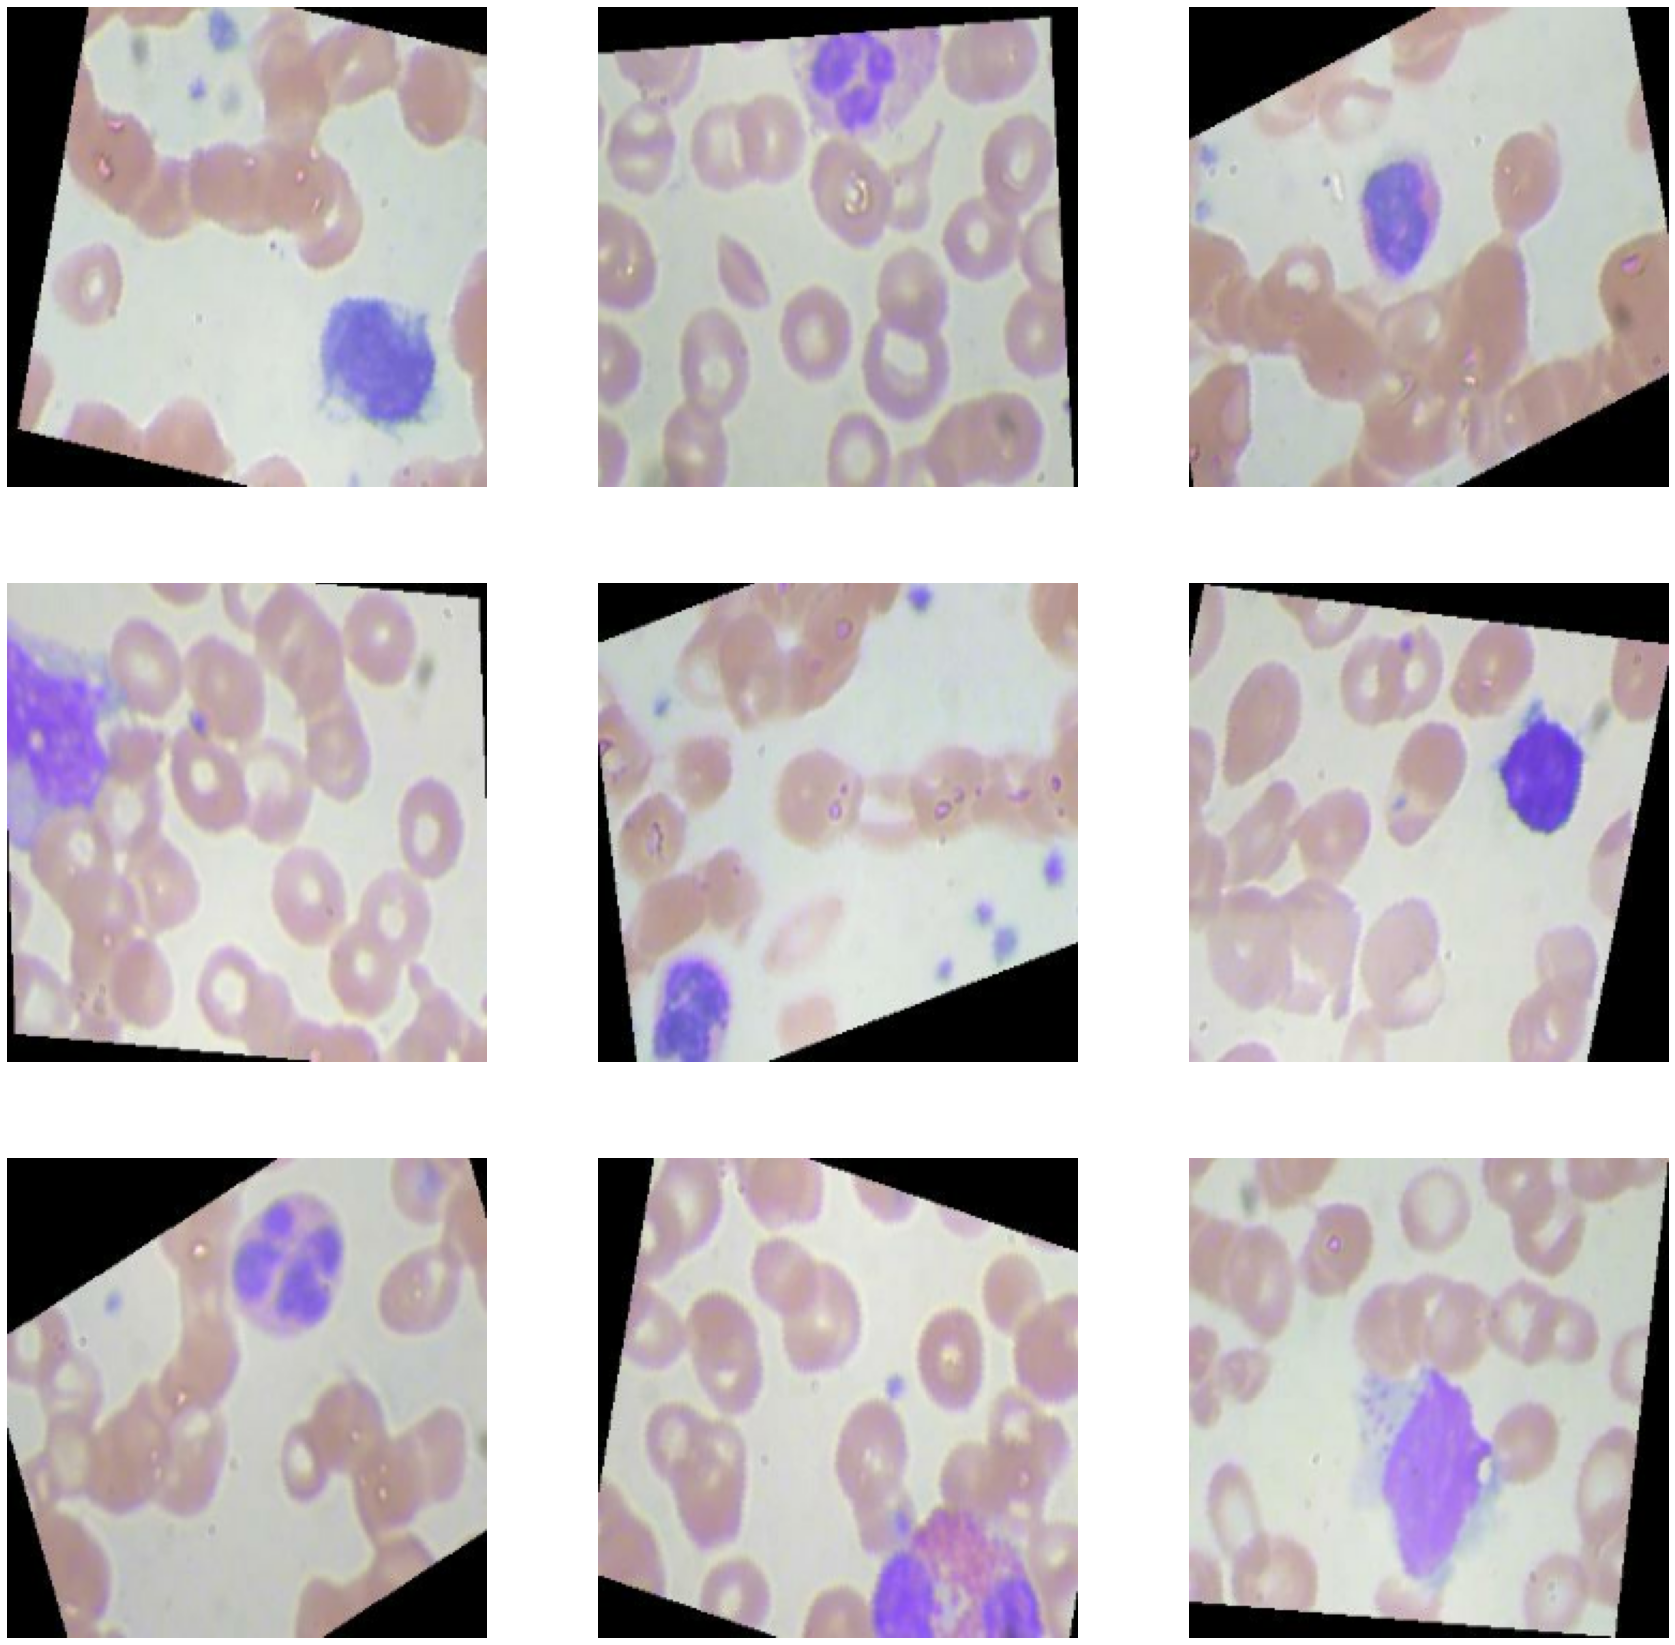

In [26]:
# solo per immagine
base_dir = "C:/Users/lucam/Desktop/Uni/Advanced Machine Learning/Assignment 4/Dataset"
df_show_img = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'] ,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=(123)
)

plt.figure(figsize=(30, 30))
for images, labels  in df_show_img.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [5]:
df_images = None
df_labels = None

for image, label in tfds.as_numpy(df):
  df_images = image
  df_labels = label

In [6]:
print(df_images.shape, df_labels.shape)

(1836, 224, 224, 3) (1836,)


In [7]:
# faccio stesso pre-processing che su immagini date alle VGG16
df_images = preprocess_input(df_images)

## First Layer (block4_pool)

The first layer of the VGG16 considered as a feature extractor is denominated 'block4_pool'.  
It is pretty close to the output of the network, cutting the VGG16 at this point provides 7,635,264 pre-trained parameters to be used. The layer itself provides a 14 x 14 x 512 size feature tensor when applied to the data.  
After having extracted these features a reshape is performed to obtain a two column matrix, containing, for each observation, the relative features. At this point a split is performed in order to create a training set and a test set.  
The sheer amount of features that all this procedures produce makes computation nearly impossible to handle. In order to be able to use a classifier a feature reduction technique is required. The choice falls on the principal component analysis (PCA).  
The data are standardized, as the PCA requires, and then a principal components analysis is applied using the maximum number of components possible. The cumulated variance explained by the components is plotted alongside the number of components used and a threshold is set. Approximately 1000 components are enough to explain more then 90% of the variance in the data, therefore only these are kept.  
The SVM is then applied to the transformed data and in order to tune the machine a cross validation procedure is used. The grid search implemented found that the configuration that can predict the highest accuracy is the one with the following parameters' values: C = 0.001, degree = 2, gamma = 0.0001, kernel = 'linear' ('gamma' and 'degree' are useless with a linear kernel, their value holds, therefore, no meaning).  
The SVM provides a 71% general accuracy on the test sample, a classification report and a confusion matrix are printed for a better understanding of the results.  
From the report it is clear that Lymphocyte, Monocyte, and Neutrophil are well classified. These classes, corrisponding to numbers 1, 2, 3, perform quite well on both precision and recall, only Neutrophil have a lower level of recall, but still a good level of precision. The 0 class, Eosinophil, however, performs quite poorly on both these statistics.  
This result is confirmed by the confusion matrix; looking at the diagonal, a high number of properly classified observations can be seen in all the classes besides the first one. It appears that the model finds particularly problematic to distinguish between images of Eosinophil and Neutrophil.

In [143]:
from tensorflow.keras import Model

base_model = VGG16(weights = 'imagenet')
model_1 = Model(inputs = base_model.inputs, outputs= base_model.get_layer('block4_pool').output)
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [144]:
feature = model_1.predict(df_images) 
print(feature.shape)

(1836, 14, 14, 512)


In [146]:
feature_reshaped = np.reshape(feature, (1836, 100352))
feature_reshaped.shape

(1836, 100352)

In [147]:
x_train, x_test, y_train, y_test = train_test_split(feature_reshaped, df_labels)
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (1377, 100352), x_test shape: (459, 100352), y_train shape: (1377,), y_test shape: (459,)


In [148]:
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1377)
x_train_pca = pca.fit_transform(x_train)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
x_train_pca.shape

(1377, 1377)

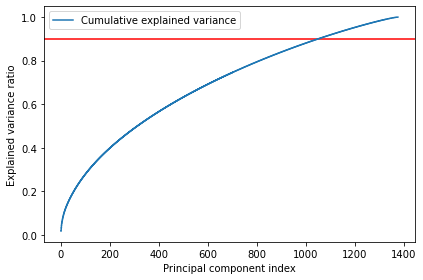

In [15]:
plt.axhline(y=0.9, color='r', linestyle='-')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# prendo le prime 1000 componenti che spiegano più del 90% della varianza

In [149]:
pca = PCA(n_components=1000)
x_train_pca = pca.fit_transform(x_train)
x_train_pca.shape

(1377, 1000)

In [150]:
x_test_pca = pca.transform(x_test)
x_test_pca.shape

(459, 1000)

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
svm_linear = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01], 
              'kernel': ['linear']} 
svm_others = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['poly', 'rbf', 'sigmoid']}

parameters = [svm_linear, svm_others]

svm_clf = svm.SVC(class_weight='balanced', decision_function_shape='ovo')
#Create the GridSearchCV object
grid_clf = GridSearchCV(estimator = svm_clf, param_grid=params_grid, verbose = 3, return_train_score=True) # 5-Folds CV

#Fit the data with the best possible parameters
grid_result = grid_clf.fit(x_train_pca, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.001, degree=2, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, degree=2, gamma=0.0001, kernel=linear, score=(train=1.000, test=0.703), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  C=0.001, degree=2, gamma=0.0001, kernel=linear, score=(train=1.000, test=0.656), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV]  C=0.001, degree=2, gamma=0.0001, kernel=linear, score=(train=1.000, test=0.640), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=2, gamma=0.0001, kernel=linear, score=(train=1.000, test=0.662), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=2, gamma=0.0001, kernel=linear, score=(train=1.000, test=0.607), total=   2.0s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=rbf .....................
[CV]  C=0.001, degree=2, gamma=0.0001, kernel=rbf, score=(train=0.247, test=0.250), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=rbf .....................
[CV]  C=0.001, degree=2, gamma=0.0001, kernel=rbf, score=(train=0.255, test=0.257), total=   2.0s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=rbf .....................
[CV]  C=0.001, degree=2, gamma=0.0001, kernel=rbf, score=(train=0.232, test=0.229), total=   2.1s
[CV] C=0.001, degree=2, gamma=0.0001, kernel=rbf

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 34.6min finished


In [152]:
#Print the best estimator with it's parameters
print("Best Accuracy: %f using %s" % (grid_clf.best_score_, grid_clf.best_params_))

Best Accuracy: 0.653557 using {'C': 0.001, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}


In [35]:
clf = svm.SVC(kernel='linear', gamma=0.0001, C= 0.001, class_weight='balanced', decision_function_shape='ovo', degree = 2)
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7058823529411765


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

# 0 = Eosinophil
# 1 = Lymphocyte
# 2 = Monocyte
# 3 = Neutrophil

              precision    recall  f1-score   support

           0       0.47      0.63      0.54        98
           1       0.83      0.77      0.80       114
           2       0.85      0.80      0.82       123
           3       0.72      0.61      0.66       124

    accuracy                           0.71       459
   macro avg       0.72      0.70      0.71       459
weighted avg       0.73      0.71      0.71       459



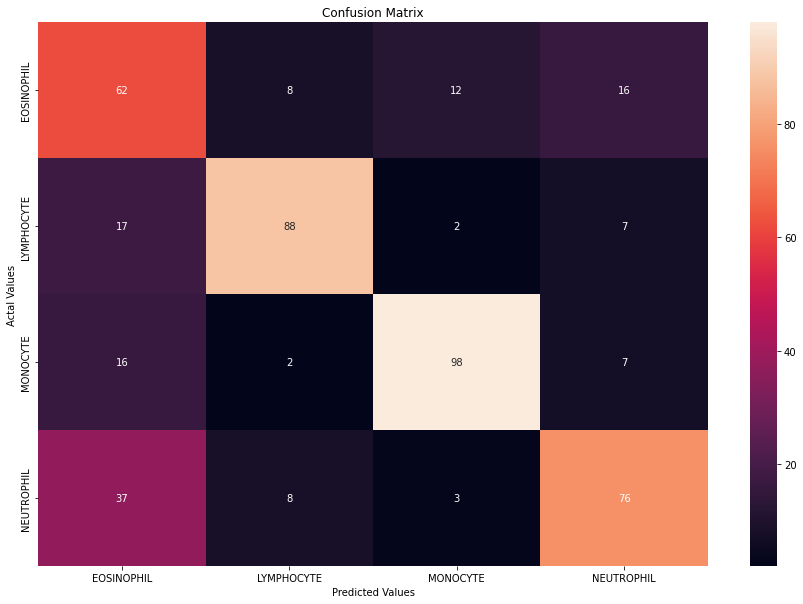

In [37]:
classes = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Second Layer (block3_pool)

For the second layer the VGG16 is cut closer to the input. As a comparison with the previous case now there are only 1,735,488 pre-trained parameters available. As far as the feature dimensions are concerned, this layer extracts a 28 x 28 x 256 tensor.  
To obtain comparable estimates with the previuous experiment there needs to be an homogeneity in the results, for this reason the same procedures are applied in this layer as well. The same PCA is used and the SVM utilizes the same parameters too.  
Using a layer closed to the input definitely worsened the calssification's results.  
For this transfer learning experiment the avarage accuracy was about 51%. Looking at the report it is clear that all classes performed preatty poorly on both precision and recall.  
The confusion matrix reveals that a lot of misclassification happens with these model. The worst examples happen when the SVM is presented with Eosinophil or Monocyte images, but, in general, poor performances and wrong classifications happen with all sorts of images. 

In [119]:
model_2 = Model(inputs = base_model.inputs, outputs= base_model.get_layer('block3_pool').output)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [120]:
feature = model_2.predict(df_images) 
print(feature.shape)

(1836, 28, 28, 256)


In [122]:
feature_reshaped = np.reshape(feature, (1836, 200704))
feature_reshaped.shape

(1836, 200704)

In [123]:
x_train, x_test, y_train, y_test = train_test_split(feature_reshaped, df_labels)
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (1377, 200704), x_test shape: (459, 200704), y_train shape: (1377,), y_test shape: (459,)


In [124]:
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [125]:
x_train_pca = pca.fit_transform(x_train)
x_train_pca.shape

(1377, 1000)

In [126]:
x_test_pca = pca.transform(x_test)
x_test_pca.shape

(459, 1000)

In [127]:
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5076252723311547


In [128]:
print(classification_report(y_test, y_pred))


# 0 = Eosinophil
# 1 = Lymphocyte
# 2 = Monocyte
# 3 = Neutrophil

              precision    recall  f1-score   support

           0       0.39      0.40      0.40       121
           1       0.59      0.63      0.61       104
           2       0.63      0.47      0.54       133
           3       0.45      0.55      0.50       101

    accuracy                           0.51       459
   macro avg       0.52      0.51      0.51       459
weighted avg       0.52      0.51      0.51       459



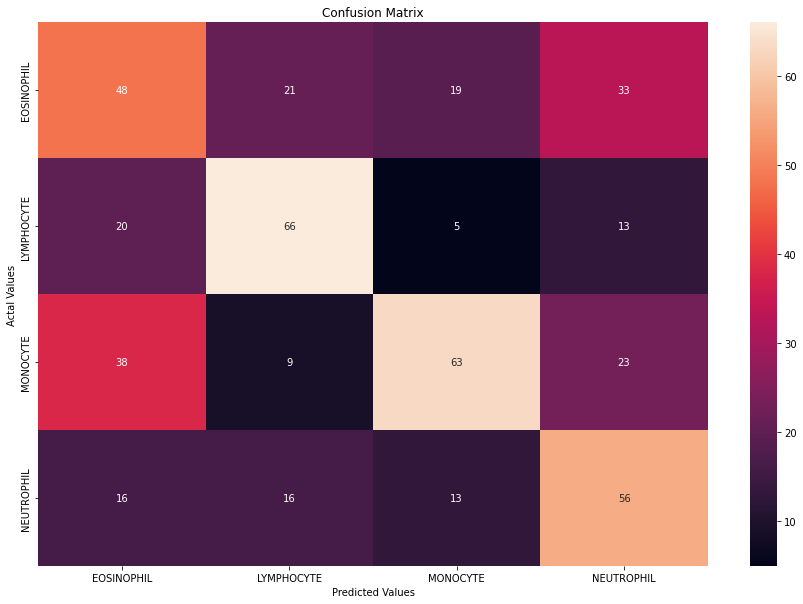

In [129]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Third Layer (block5_pool)

Given that the performances of the SVM seem to worsen if a layer is cut too close to the input, now the opposite situation in tested.  
For this experiment a 'block5_pool' is selected as the cutting point, that is two pooling layers after the previous case, way closer to the output of the VGG16. By doing so the number of pre-trained parametrs increases, reaching 14,714,688. On the other hand the feature size is reduced to a 7 x 7 x 512 tensor.  
For the reasons stated above the same PCA and the same SVM parameters are used in this case as well.  
As expected, this time the classifier performed way better than the previous case and a little better than the first experiment.  
The avarage accuracy is around 72% and the values of precision and recall for all 4 classes are very similar to the one presented in the first case, just slightly improved. In particular the problematic class 0 has experienced a large benefit from the new cut, even through, it is still the worst performing out of all 4 classes. 

The confusion matrix clearly highlights the improvement; as expected, the diagonal has highter numbers of correclty classified observations for all the classes, and, in particular, the first class is subjected to way less misclassification than previously was.  

In [130]:
model_3 = Model(inputs = base_model.inputs, outputs= base_model.get_layer('block5_pool').output)
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [131]:
feature = model_3.predict(df_images) 
print(feature.shape)

(1836, 7, 7, 512)


In [133]:
feature_reshaped = np.reshape(feature, (1836, 25088))
feature_reshaped.shape

(1836, 25088)

In [134]:
x_train, x_test, y_train, y_test = train_test_split(feature_reshaped, df_labels)
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (1377, 25088), x_test shape: (459, 25088), y_train shape: (1377,), y_test shape: (459,)


In [135]:
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [136]:
x_train_pca = pca.fit_transform(x_train)
x_train_pca.shape

(1377, 1000)

In [137]:
x_test_pca = pca.transform(x_test)
x_test_pca.shape

(459, 1000)

In [138]:
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7211328976034859


In [139]:
print(classification_report(y_test, y_pred))

# 0 = Eosinophil
# 1 = Lymphocyte
# 2 = Monocyte
# 3 = Neutrophil

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       124
           1       0.75      0.81      0.78       117
           2       0.71      0.89      0.79        90
           3       0.77      0.67      0.72       128

    accuracy                           0.72       459
   macro avg       0.72      0.73      0.72       459
weighted avg       0.72      0.72      0.72       459



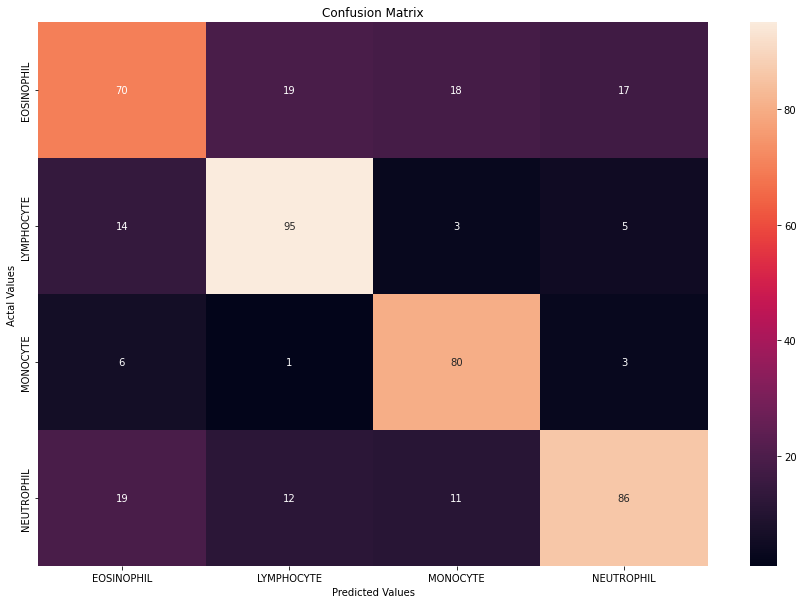

In [140]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Conclusions

The new dataset, the one concerning blood cell types, is small but very different from the original dataset, IMAGENET, therefore, in order to train a classifier properly, we should expect to use CNN features from lower layers. This because later layers of the CNN become progressively more specific to
the details of the classes contained in the original dataset.  
The experiments performed, on the other hand, showed that in this specific case the closer the cut got to the output, the more specific the VGG16's features were, the more accurate the prediction on the blood cells dataset could be performed. This was a completely unexpected outcome.  
A possible explanation could be that the idea and features telling a cell apart from anothere are not that different from the features telling the some objects in the IMAGENET apart from each other.
